In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image

import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math

# Define the path to save the model in Google Drive
model_path = '/Users/javiilaing/Documents/PhD/Probabilistic_Machine_Learning/Final_project/ddpm_model2_100epochs.pth'


This code implements a denoising diffusion probabilistic model (DDPM)
These models objective is to learn a generative model by reversing a noising
process (diffusion process). The model adds noise to the data progressively with its forward process $q(x_t | x_{t-1})$ adding Gaussian noise to data over T timesteps. Followed by a reverse process $p(x_{t-1} | x_t)$ where the model learns to reverse the noising process to generate the samples.

Training:   0%|          | 0/23500 [00:00<?, ?it/s]

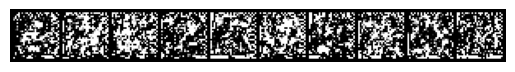

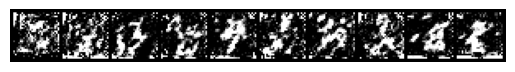

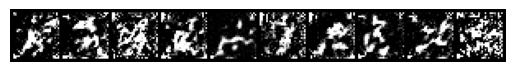

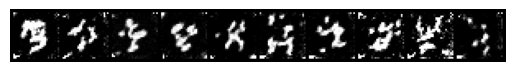

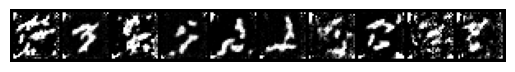

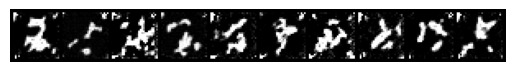

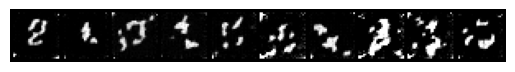

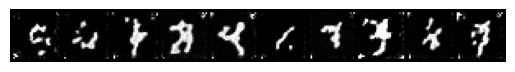

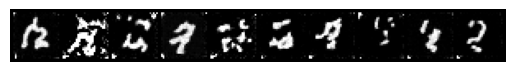

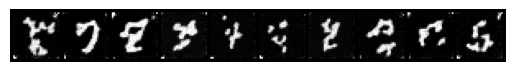

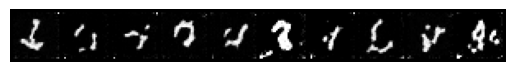

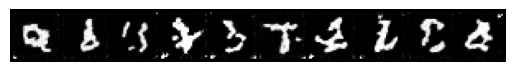

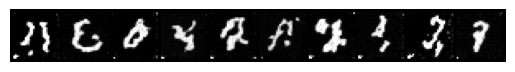

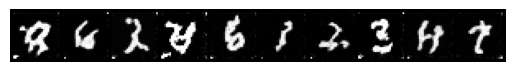

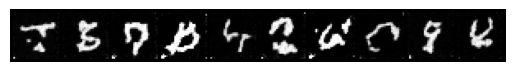

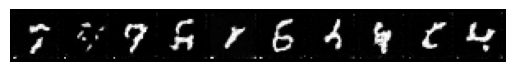

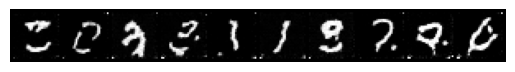

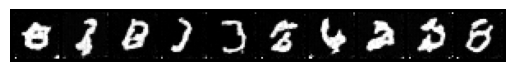

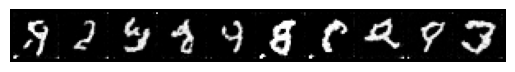

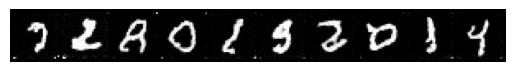

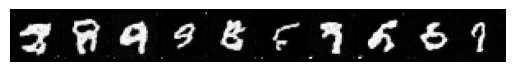

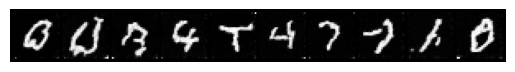

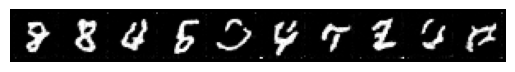

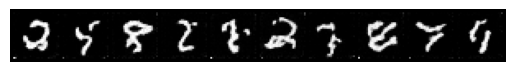

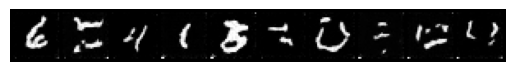

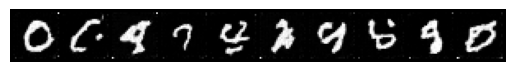

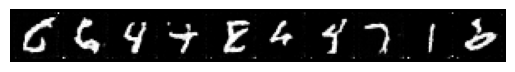

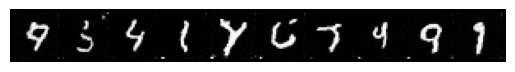

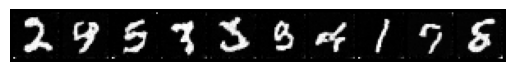

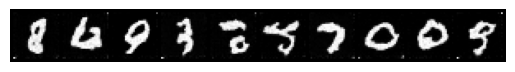

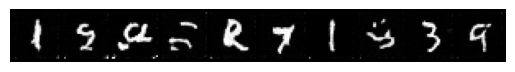

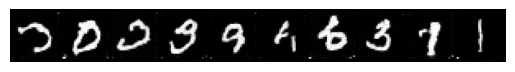

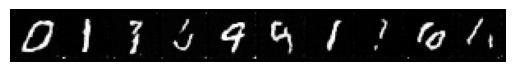

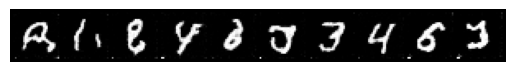

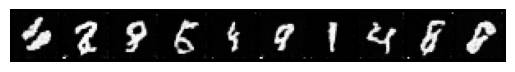

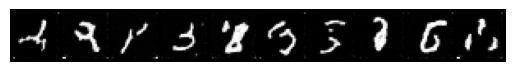

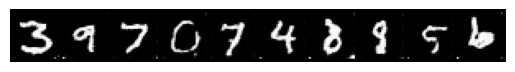

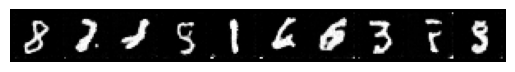

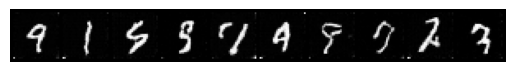

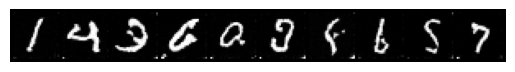

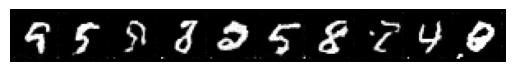

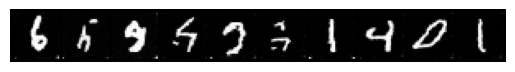

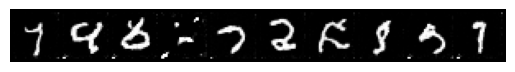

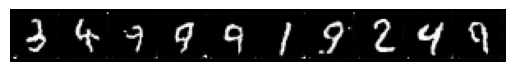

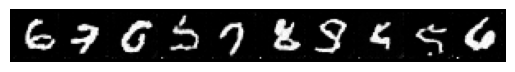

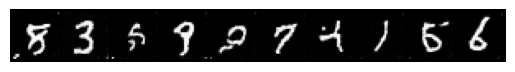

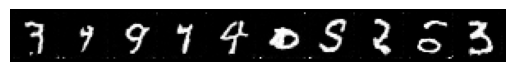

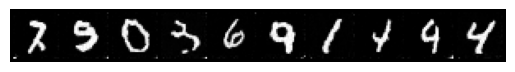

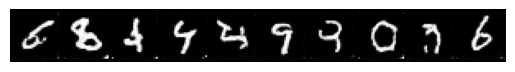

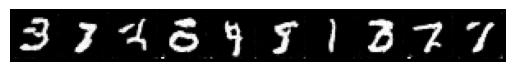

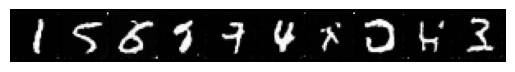

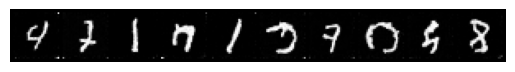

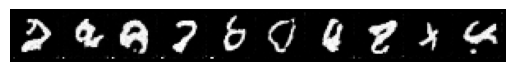

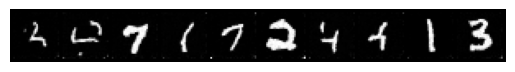

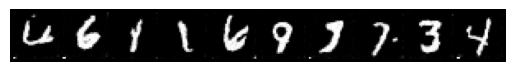

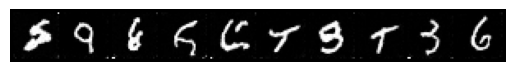

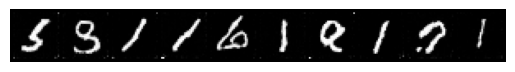

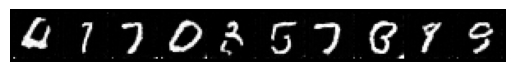

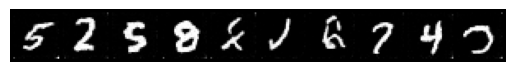

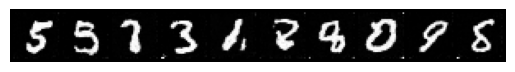

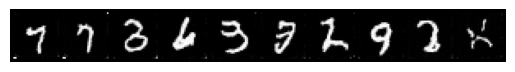

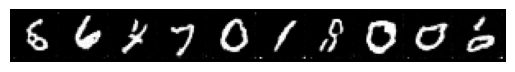

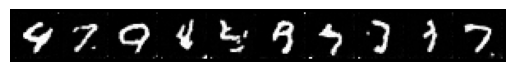

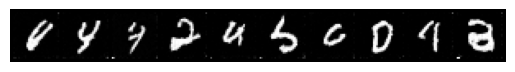

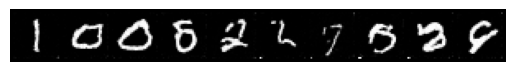

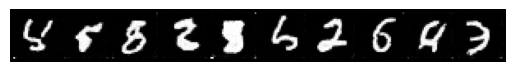

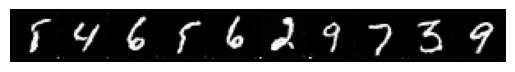

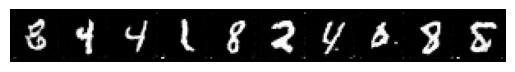

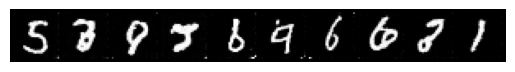

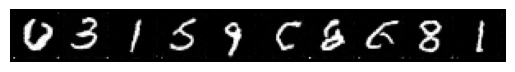

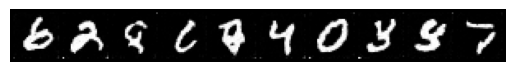

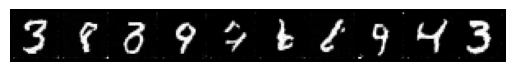

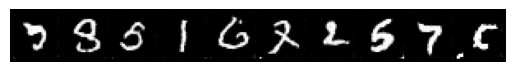

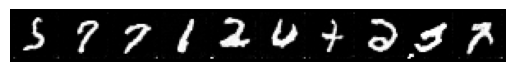

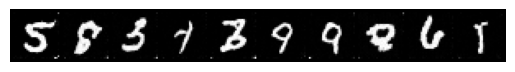

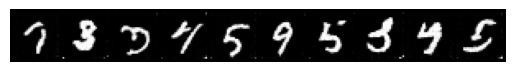

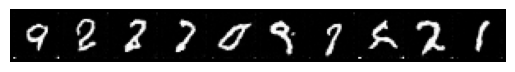

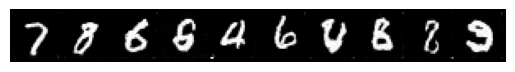

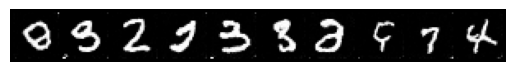

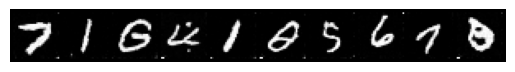

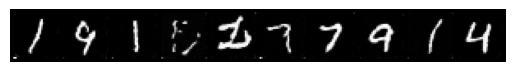

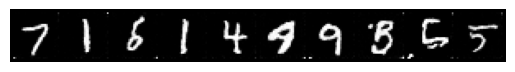

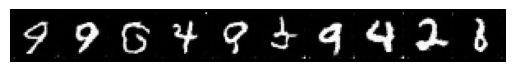

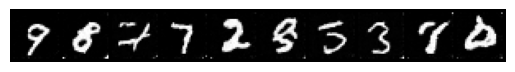

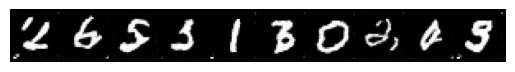

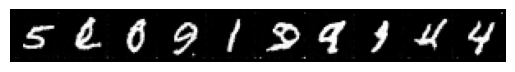

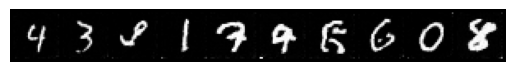

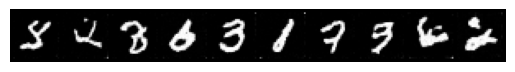

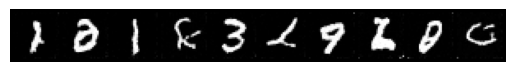

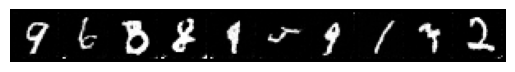

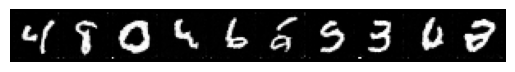

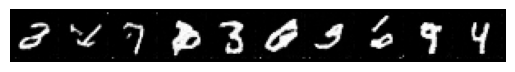

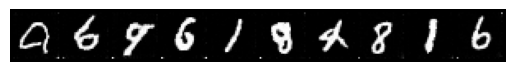

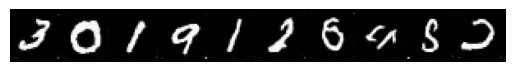

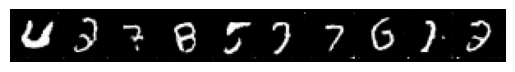

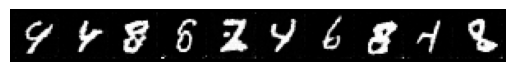

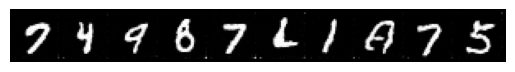

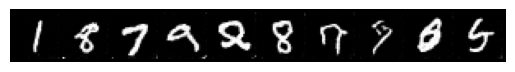

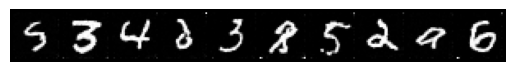

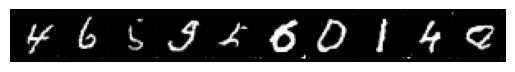

In [3]:
# This UNET-style prediction model was originally included as part of the Score-based generative modelling tutorial
# by Yang Song et al: https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing

class GaussianFourierProjection(nn.Module):
    
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
    
    
    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        
        
        super().__init__()
        # Gaussian random feature embedding layer for time
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
             nn.Linear(embed_dim, embed_dim))
        # Encoding layers where the resolution decreases
        # Downsamples input to extract features
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # Decoding layers where the resolution increases
        # Upsamples features while incorporating information from encoding layers.
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)  # sigmoid ensures smoother gradients
        self.marginal_prob_std = marginal_prob_std
    
    def forward(self, x, t):
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.embed(t))
        # Encoding path
        h1 = self.conv1(x)
        ## Incorporate information from t
        h1 += self.dense1(embed)
        ## Group normalization
        h1 = self.gnorm1(h1)
        h1 = self.act(h1)
        h2 = self.conv2(h1)
        h2 += self.dense2(embed)
        h2 = self.gnorm2(h2)
        h2 = self.act(h2)
        h3 = self.conv3(h2)
        h3 += self.dense3(embed)
        h3 = self.gnorm3(h3)
        h3 = self.act(h3)
        h4 = self.conv4(h3)
        h4 += self.dense4(embed)
        h4 = self.gnorm4(h4)
        h4 = self.act(h4)

        # Decoding path
        h = self.tconv4(h4)
        ## Skip connection from the encoding path -> it helps recover spatial information lost during downsampling
        h += self.dense5(embed)
        h = self.tgnorm4(h)
        h = self.act(h)
        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.tgnorm3(h)
        h = self.act(h)
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.tgnorm2(h)
        h = self.act(h)
        h = self.tconv1(torch.cat([h, h1], dim=1))

        # Normalize output -> this helps with the stability
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h
    
class ExponentialMovingAverage(torch.optim.swa_utils.AveragedModel):
    

    def __init__(self, model, decay, device="cpu"):
        def ema_avg(avg_model_param, model_param, num_averaged):
            return decay * avg_model_param + (1 - decay) * model_param

        super().__init__(model, device, ema_avg, use_buffers=True)

class DDPM(nn.Module):

    def __init__(self, network, T=100, beta_1=1e-4, beta_T=2e-2):
        
        super(DDPM, self).__init__()

        # Normalize time input before evaluating neural network
        # Reshape input into image format and normalize time value before sending it to network model
        self._network = network
        self.network = lambda x, t: (self._network(x.reshape(-1, 1, 28, 28),
                                                   (t.squeeze()/T))
                                    ).reshape(-1, 28*28)

        # Total number of time steps
        self.T = T

        # Registering as buffers to ensure they get transferred to the GPU automatically
        self.register_buffer("beta", torch.linspace(beta_1, beta_T, T+1))
        self.register_buffer("alpha", 1-self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(dim=0))


    def forward_diffusion(self, x0, t, epsilon):
        

        # Xt = sqrt(alpha_bar_t)X0 + sqrt(1 - alpha_bar_t) epsilon
        # Xt = mean + std*epsilon

        # The mean scales the original data x0 according to the noise schedule
        # this ensures that the contribution of the original data diminishes
        # as the t increases.
        mean = torch.sqrt(self.alpha_bar[t])*x0

        # The standard deviation determines how much Gaussian noise is added at
        # with every timestamp t
        std = torch.sqrt(1 - self.alpha_bar[t])

        # retur Xt
        return mean + std*epsilon

    def reverse_diffusion(self, xt, t, epsilon):
        
        # xt is the current noisy sample, network predicts noise epsilon added to xt
        # by substacting (self.beta[t])/torch.sqrt(1-self.alpha_bar[t])*self.network(xt, t)
        # from xt we are removing the noise predicted by the network
        mean =  1./torch.sqrt(self.alpha[t]) * (xt - (self.beta[t])/torch.sqrt(1-self.alpha_bar[t])*self.network(xt, t))

        # std is derived by the forward process and ensures the reverse process
        # is aligned with the noise schedule. When t = 0 there should not be
        # more noise
        std = torch.where(t>0, torch.sqrt(((1-self.alpha_bar[t-1]) / (1-self.alpha_bar[t]))*self.beta[t]), 0)

        return mean + std*epsilon


    @torch.no_grad()
    def sample(self, shape):

        # Sample xT: Gaussian noise
        xT = torch.randn(shape).to(self.beta.device)

        xt = xT
        for t in range(self.T, 0, -1):
            noise = torch.randn_like(xT) if t > 1 else 0
            t = torch.tensor(t).expand(xt.shape[0], 1).to(self.beta.device)
            xt = self.reverse_diffusion(xt, t, noise)

        return xt


    def elbo_simple(self, x0):

        # Sample time step t
        t = torch.randint(1, self.T, (x0.shape[0],1)).to(x0.device)

        # Sample noise
        epsilon = torch.randn_like(x0)

        # TODO: Forward diffusion to produce image at step t
        xt = self.forward_diffusion(x0, t, epsilon)

        # loss simple
        return -nn.MSELoss(reduction='mean')(epsilon, self.network(xt, t))


    def loss(self, x0):
        
        return -self.elbo_simple(x0).mean()


def train(model, optimizer, scheduler, dataloader, epochs, device, ema=True, per_epoch_callback=None):
    

    # Setup progress bar
    total_steps = len(dataloader)*epochs
    progress_bar = tqdm(range(total_steps), desc="Training")

    if ema:
        ema_global_step_counter = 0
        ema_steps = 10
        ema_adjust = dataloader.batch_size * ema_steps / epochs
        ema_decay = 1.0 - 0.995
        ema_alpha = min(1.0, (1.0 - ema_decay) * ema_adjust)
        ema_model = ExponentialMovingAverage(model, device=device, decay=1.0 - ema_alpha)

    for epoch in range(epochs):

        # Switch to train mode
        model.train()

        global_step_counter = 0
        for i, (x, _) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            loss = model.loss(x)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Update progress bar
            progress_bar.set_postfix(loss=f"⠀{loss.item():12.4f}", epoch=f"{epoch+1}/{epochs}", lr=f"{scheduler.get_last_lr()[0]:.2E}")
            progress_bar.update()

            if ema:
                ema_global_step_counter += 1
                if ema_global_step_counter%ema_steps==0:
                    ema_model.update_parameters(model)

        if per_epoch_callback:
            per_epoch_callback(ema_model.module if ema else model)


# Parameters
T = 1000
learning_rate = 1e-3
epochs = 100
batch_size = 256


# Rather than treating MNIST images as discrete objects, as done in Ho et al 2020,
# we here treat them as continuous input data, by dequantizing the pixel values (adding noise to the input data)
# Also note that we map the 0..255 pixel values to [-1, 1], and that we process the 28x28 pixel values as a flattened 784 tensor.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + torch.rand(x.shape)/255),    # Dequantize pixel values
    transforms.Lambda(lambda x: (x-0.5)*2.0),                    # Map from [0,1] -> [-1, -1]
    transforms.Lambda(lambda x: x.flatten())
])

# Download and transform train dataset
dataloader_train = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', download=True, train=True, transform=transform),
                                                batch_size=batch_size,
                                                shuffle=True)

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Construct Unet
# The original ScoreNet expects a function with std for all the
# different noise levels, such that the output can be rescaled.
# Since we are predicting the noise (rather than the score), we
# ignore this rescaling and just set std=1 for all t.
mnist_unet = ScoreNet((lambda t: torch.ones(1).to(device)))

# Construct model
model = DDPM(mnist_unet, T=T).to(device)

# Construct optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Setup simple scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)


def reporter(model):
    # Switch to eval mode
    model.eval()

    with torch.no_grad():
        nsamples = 10
        samples = model.sample((nsamples,28*28)).cpu()

        # Map pixel values back from [-1,1] to [0,1]
        samples = (samples+1)/2
        samples = samples.clamp(0.0, 1.0)

        # Plot in grid
        grid = utils.make_grid(samples.reshape(-1, 1, 28, 28), nrow=nsamples)
        plt.gca().set_axis_off()
        plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
        plt.show()


# Call training loop
train(model, optimizer, scheduler, dataloader_train, epochs=epochs, device=device, ema=True, per_epoch_callback=reporter)


# Save the model
#torch.save(model.state_dict(), model_path)
#print(f"Model saved successfully to {model_path}!")


So far, we have considered only models generating samples from the entire distribution. How can we get diffusion models to generate samples conditionally
- e.g. sampling only MNIST images corresponding to the digit 4?
There are (at least) two ways of achieving this in diffusion models - either
through “Classifier guided diffusion”, or through “Classifier-free guidance”.
The two approaches are explained in blog posts by Lilian Weng6 and Sander
Dieleman7. Implement one or both of these techniques to make it possible
to generate images of specific digits. If you implement both strategies, assess
which ones performs best

In [13]:
# Define a simple CNN Classifier for our task
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Reshape flattened input to [batch_size, 1, 28, 28]
        x = x.view(-1, 1, 28, 28)
        x = nn.ReLU()(self.conv1(x))
        x = nn.MaxPool2d(2, 2)(x)
        x = nn.ReLU()(self.conv2(x))
        x = nn.MaxPool2d(2, 2)(x)
        x = x.view(-1, 64 * 7 * 7)
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x
    
# Rather than treating MNIST images as discrete objects, as done in Ho et al 2020,
# we here treat them as continuous input data, by dequantizing the pixel values (adding noise to the input data)
# Also note that we map the 0..255 pixel values to [-1, 1], and that we process the 28x28 pixel values as a flattened 784 tensor.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + torch.rand(x.shape)/255),    # Dequantize pixel values
    transforms.Lambda(lambda x: (x-0.5)*2.0),                    # Map from [0,1] -> [-1, -1]
    transforms.Lambda(lambda x: x.flatten())
])

# Download and transform train dataset
dataloader_train_classifier = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', download=True, train=True, transform=transform),
                                                batch_size=batch_size,
                                                shuffle=True)
# Load the MNIST test dataset
test_dataset = datasets.MNIST('./mnist_data', download=True, train=False, transform=transform)

# Create a DataLoader for the test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


# Initialize model, loss, optimizer
classifier = MNISTClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=1e-3)


# Train the classifier
classifier.train()
for epoch in range(10):
    for images, labels in dataloader_train_classifier:
        optimizer.zero_grad()
        outputs = classifier(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

# Save the trained classifier
#torch.save(classifier.state_dict(), "/Users/javiilaing/Documents/PhD/Probabilistic_Machine_Learning/Final_project/mnist_classifier_100epochs.pth")

# Evaluate classifier accuracy
classifier.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = classifier(images)
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
print(f"Classifier Accuracy: {correct / total * 100:.2f}%")

Epoch 1, Loss: 0.03637329116463661
Epoch 2, Loss: 0.02025509811937809
Epoch 3, Loss: 0.03846945986151695
Epoch 4, Loss: 0.00968706700950861
Epoch 5, Loss: 0.04262324050068855
Epoch 6, Loss: 0.011060807853937149
Epoch 7, Loss: 0.011175070889294147
Epoch 8, Loss: 0.008197751827538013
Epoch 9, Loss: 0.03072028048336506
Epoch 10, Loss: 0.0009721535607241094
Classifier Accuracy: 99.02%


cpu
t_tensor shape: torch.Size([4, 1])


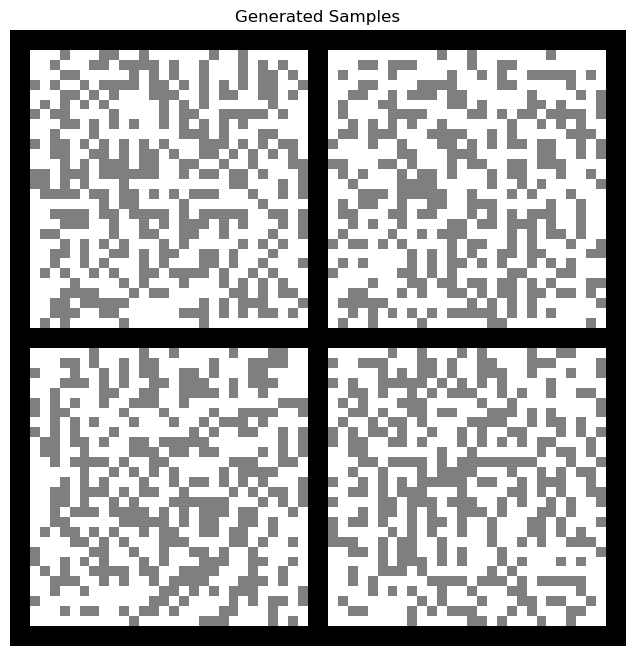

In [9]:
def classifier_guided_sample(model, classifier, num_samples, guidance_scale=1.0, target_digit=4):
    
    model.eval()
    classifier.eval()
    device = next(model.parameters()).device
    classifier = classifier.to(device)

    # Initialize with Gaussian noise
    x_t = torch.randn((num_samples, 28 * 28)).to(device)

    for t in range(model.T, 0, -1):
        #print(t)
    
        t_tensor = torch.tensor(t, device=device).expand(num_samples, 1)

        # Debugging: Print the shape of t_tensor to verify
        if t == model.T:  
            print(f"t_tensor shape: {t_tensor.shape}")

        # Predict noise using the diffusion model
        epsilon_theta = model.network(x_t, t_tensor)

        # Compute classifier gradients
        x_t_reshaped = x_t.view(-1, 1, 28, 28).requires_grad_(True)
        logits = classifier(x_t_reshaped)
        log_probs = F.log_softmax(logits, dim=1)
        selected_log_prob = log_probs[:, target_digit].sum()
        grad = torch.autograd.grad(selected_log_prob, x_t_reshaped)[0].view(-1, 28 * 28)

        # Adjust predicted noise with classifier guidance
        sigma_t = torch.sqrt(model.beta[t])  # Use t (int) for indexing
        epsilon_theta = epsilon_theta - guidance_scale * sigma_t * grad

        # Perform reverse diffusion step
        noise = torch.randn_like(x_t) if t > 1 else torch.zeros_like(x_t)
        #t_index = torch.tensor(t, device=device, dtype=torch.long)  
        x_t = model.reverse_diffusion(x_t, t_tensor, epsilon_theta)

    # Reshape and scale samples back to image format
    samples = x_t.view(-1, 1, 28, 28)
    samples = (samples + 1) / 2  # Scale from [-1, 1] to [0, 1]
    samples = samples.clamp(0, 1)

    return samples


def reporter(samples, num_samples=16):

    # Map pixel values back from [-1,1] to [0,1]
    samples = (samples + 1) / 2
    samples = samples.clamp(0.0, 1.0)

    # Plot in grid
    grid = make_grid(samples.view(-1, 1, 28, 28), nrow=int(num_samples ** 0.5))
    plt.figure(figsize=(8, 8))
    plt.gca().set_axis_off()
    plt.imshow(to_pil_image(grid), cmap="gray")
    plt.title("Generated Samples")
    plt.show()

    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#Load a pre trained MNIST classifier 
loaded_classifier = MNISTClassifier()
loaded_classifier.load_state_dict(torch.load('/Users/javiilaing/Documents/PhD/Probabilistic_Machine_Learning/Final_project/mnist_classifier_100epochs.pth'))
loaded_classifier = loaded_classifier.to(device)
loaded_classifier.eval()

network = ScoreNet((lambda t: torch.ones(1).to(device)))
loaded_model = DDPM(network, T = 1000).to(device)
loaded_model.load_state_dict(torch.load('/Users/javiilaing/Documents/PhD/Probabilistic_Machine_Learning/Final_project/ddpm_model2_100epochs.pth', map_location=torch.device('cpu')))
loaded_model = loaded_model.to(device)
loaded_model.eval()


# Generate samples for the digit '4'
num_samples = 4 # Adjust the number of samples as needed
samples = classifier_guided_sample(
    model=loaded_model,
    classifier=loaded_classifier,
    num_samples=num_samples,
    guidance_scale=6,
    target_digit=4
)

reporter(samples, num_samples=num_samples)

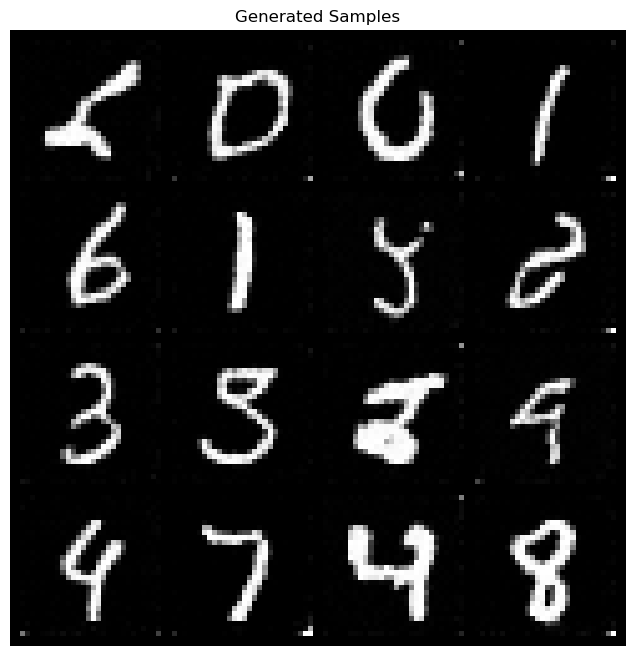

In [10]:
samples = loaded_model.sample((16, 28 * 28)).view(-1, 1, 28, 28)
reporter(samples, num_samples=16)

In [ ]:
class ClassifierFreeScoreNet(ScoreNet):
    def forward(self, x, t, y=None, guidance_scale=1.0):
       
        if y is not None:
            # Conditional prediction
            cond_embed = self.embed(y)  
            cond_output = super().forward(x, t + cond_embed)

            # Unconditional prediction
            uncond_embed = torch.zeros_like(cond_embed)
            uncond_output = super().forward(x, t + uncond_embed)

            # Combine predictions with guidance scale
            return uncond_output + guidance_scale * (cond_output - uncond_output)
        else:
            # Unconditional prediction
            return super().forward(x, t)

def train_classifier_free(model, optimizer, dataloader, epochs, device, label_dropout_prob=0.1):
    
    model.train()
    for epoch in range(epochs):
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Drop class labels with probability label_dropout_prob
            drop_mask = (torch.rand(labels.shape, device=device) < label_dropout_prob)
            labels[drop_mask] = None  # Replace with None for unconditional

            optimizer.zero_grad()
            loss = model.loss(images, labels)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

@torch.no_grad()
def classifier_free_sample(model, num_samples, guidance_scale, target_digit):
    
    #Generate samples using classifier-free guidance.


    device = next(model.parameters()).device

    # Initialize with Gaussian noise
    x_t = torch.randn((num_samples, 1, 28, 28), device=device)

    for t in range(model.T, 0, -1):
        t_tensor = torch.tensor([t / model.T], device=device).repeat(num_samples, 1)

        # Generate conditional and unconditional predictions
        y = torch.full((num_samples,), target_digit, device=device)  
        x_t = model.reverse_diffusion(x_t, t_tensor, y, guidance_scale)

    return x_t

# Generate samples
num_samples = 16
samples = classifier_free_sample(model=loaded_model, num_samples=num_samples, guidance_scale=2.0, target_digit=4)

# Display samples in a grid
grid = make_grid(samples, nrow=4, padding=2, normalize=True)
plt.figure(figsize=(8, 8))
plt.imshow(to_pil_image(grid), cmap="gray")
plt.axis("off")
plt.title("Classifier-Free Guided Samples for Digit 4")
plt.show()